In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip, glob, os, csv
import seaborn as sns

from cdt.metrics import SID, SHD
import scipy.linalg as slin
import scipy.optimize as sopt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import copy


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
def L1(target, pred):
    return np.sum(np.abs(target - pred))

def binarize(X):
    return (X != 0) * 1

def get_precision(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp = (w_bin * (w_true_bin == 0)).sum()
    tp = (w_bin * w_true_bin).sum()

    return tp / (fp + tp)

def get_recall(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp = (w_bin * (w_true_bin == 0)).sum()
    fn = ((w_bin == 0) * w_true_bin).sum()
    tp = (w_bin * w_true_bin).sum()
    
    return tp / (tp + fn)

In [4]:
def get_fdr(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp = (w_bin * (w_true_bin == 0)).sum()
    tp = (w_bin * w_true_bin).sum()
    return fp / (fp + tp)

def get_inferred_fp_edge_weights(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp_mat = (w_bin * (w_true_bin == 0)).astype(bool)
    return w[fp_mat]
    
def get_true_fn_edge_weights(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fn_mat = ((w_bin == 0) * w_true_bin).astype(bool)
    return w_true[fn_mat]

In [5]:
METHODS = [
    'dotears', 
    'notears', 
    'sortnregress', 
    'golem-ev', 
    'golem-nv', 
    'direct-lingam', 
    'gies', 
    'igsp', 
    'ut-igsp',
    'dcdi-g',
    'colide-nv'
]

DAG_MODELS = ['erdos_renyi', 'scale_free']



In [6]:
RUN_NAMES = [
    'p40_high_density_strong_effects', 
    'p40_high_density_weak_effects',
    'p40_low_density_strong_effects',
    'p40_low_density_weak_effects'
]

all_runs = [(base_name,
             '/u/home/a/asxue/project-hjp/dotears/data/{}/out/'.format(base_name),
             '/u/home/a/asxue/project-hjp/dotears/data/{}/dags/'.format(base_name),
             '/u/home/a/asxue/project-hjp/dotears/data/{}/data/'.format(base_name)
            ) for base_name in RUN_NAMES]

w_threshold_dict = {
    'p40_high_density_strong_effects': 0.3,
    'p40_high_density_weak_effects': 0.2, 
    'p40_low_density_strong_effects': 0.3,
    'p40_low_density_weak_effects': 0.2
}

experiments = [
    'standard'
]

In [7]:
df = pd.DataFrame(columns=['method', 'L1 dist', 'SHD', 'p', 'fdr', 'DAG type', 'sim type', 'precision', 'recall', 'sim id'])
dags = []
fdr_df = pd.DataFrame(columns=['fdr', 'w', 'method', 'type'])

param_grids = []

for base_name, out_dir, true_dir, data_dir in all_runs:
    for experiment in experiments:
        out_dir = os.path.join(out_dir, 'standard')
        true_dir = os.path.join(true_dir, 'standard')
        data_dir = os.path.join(data_dir, 'standard')


        for method in METHODS:
            for dag_model in DAG_MODELS:
                for dag_num, dag in enumerate(glob.glob(os.path.join(true_dir, dag_model, '*'))):
                    w_true = np.loadtxt(dag)
                    path = os.path.join(out_dir, method, dag)

                    sim = os.path.basename(dag).split('.')[0]
                    sim_id = sim.split('_')[1]
                    
                    if int(sim_id) >= 10:
                        continue

                    path = os.path.join(out_dir, dag_model, method, sim + '.npy')
                    try:
                        W = np.load(path)
                    except:
                        continue
                        
                    dags.append([w_true, W, method, dag_model, base_name])

                    if method in METHODS:
                        W[np.abs(W) < w_threshold_dict[base_name]] = 0
                        pass

                    l1_dist = L1(w_true, W)
                    shd = SHD(binarize(w_true), binarize(W), double_for_anticausal=False)


                    fdr = get_fdr(w_true, W)
                    prec = get_precision(w_true, W)
                    recall = get_recall(w_true, W)
                    df.loc[len(df.index), :] = [method, 
                                                l1_dist,
                                                shd,
                                                W.shape[0],
                                                fdr,
                                                dag_model,
                                                base_name,
                                                prec,
                                                recall,
                                                int(sim_id)
                                               ]   

        #                 X = w_true * np.abs(binarize(w_true) - binarize(W))
                

In [8]:
for base_name in df['sim type'].unique():
    print(base_name)
    print(df.loc[df['sim type'] == base_name, 'sim id'].unique())

p40_high_density_strong_effects
[0 1 2 3 4 5 6 7 8 9]
p40_high_density_weak_effects
[0 1 2 3 4 5 6 7 8 9]
p40_low_density_strong_effects
[0 1 2 3 4 5 6 7 8 9]
p40_low_density_weak_effects
[0 1 2 3 4 5 6 7 8 9]


In [9]:
df = df.loc[df['sim id'] < 10, :]

In [10]:
mpl.style.use('ggplot')
# plt.style.use(['science'])

plt.rcParams['lines.linewidth']= 3
plt.rcParams['axes.facecolor']= 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'

plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color']= 'black'

plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['axes.labelsize'] = 32
plt.rcParams['axes.titlesize'] = 32


plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8


plt.rcParams['text.usetex'] = False

plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.linewidth'] = 2

mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica') 

# colormap = ['#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD'] #light
colormap = [
    '#59C7EB', 
    '#E0607E',  
    '#0A9086', 
    '#FEA090', 
    '#3E5496', 
    '#EFDC60', 
    '#8E2043', 
    '#9AA0A7', 
    '#077187', 
    'orange',
    'orchid'
] #unikn pal pref

HUE_METHODS = [
    'dotears', 
    'gies', 
    'notears', 
    'sortnregress', 
    'direct-lingam', 
    'igsp', 
    'golem-nv', 
    'golem-ev', 
    'ut-igsp', 
    'dcdi-g',
    'colide-nv'
]
# HUE_METHODS = ['dotears', 'sortnregress', 'notears', 'gies', 'golem-nv', 'igsp', 'direct-lingam', 'golem-ev']
CV_NAME_DICT = {
    'dotears': 'dotears*',
    'gies': 'GIES',
    'notears': 'NO TEARS*',
    'sortnregress': 'sortnregress*',
    'golem-nv': 'GOLEM-NV*',
    'igsp': 'IGSP',
    'direct-lingam': 'DirectLiNGAM',
    'golem-ev': 'GOLEM-EV*',
    'ut-igsp': 'UT-IGSP',
    'dcdi-g': 'DCDI-G*',
    'colide-nv': 'CoLiDE-NV*'

}

color_dict = {
    x[0]: x[1] for x in zip(HUE_METHODS, colormap)
}


['dotears', 'sortnregress', 'notears', 'colide-nv', 'gies', 'dcdi-g', 'golem-nv', 'ut-igsp', 'igsp', 'direct-lingam', 'golem-ev']


Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

DAG type = erdos_renyi | sim type = p40_low_density_strong_effects
DAG type = erdos_renyi | sim type = p40_low_density_weak_effects
DAG type = erdos_renyi | sim type = p40_high_density_strong_effects
DAG type = erdos_renyi | sim type = p40_high_density_weak_effects


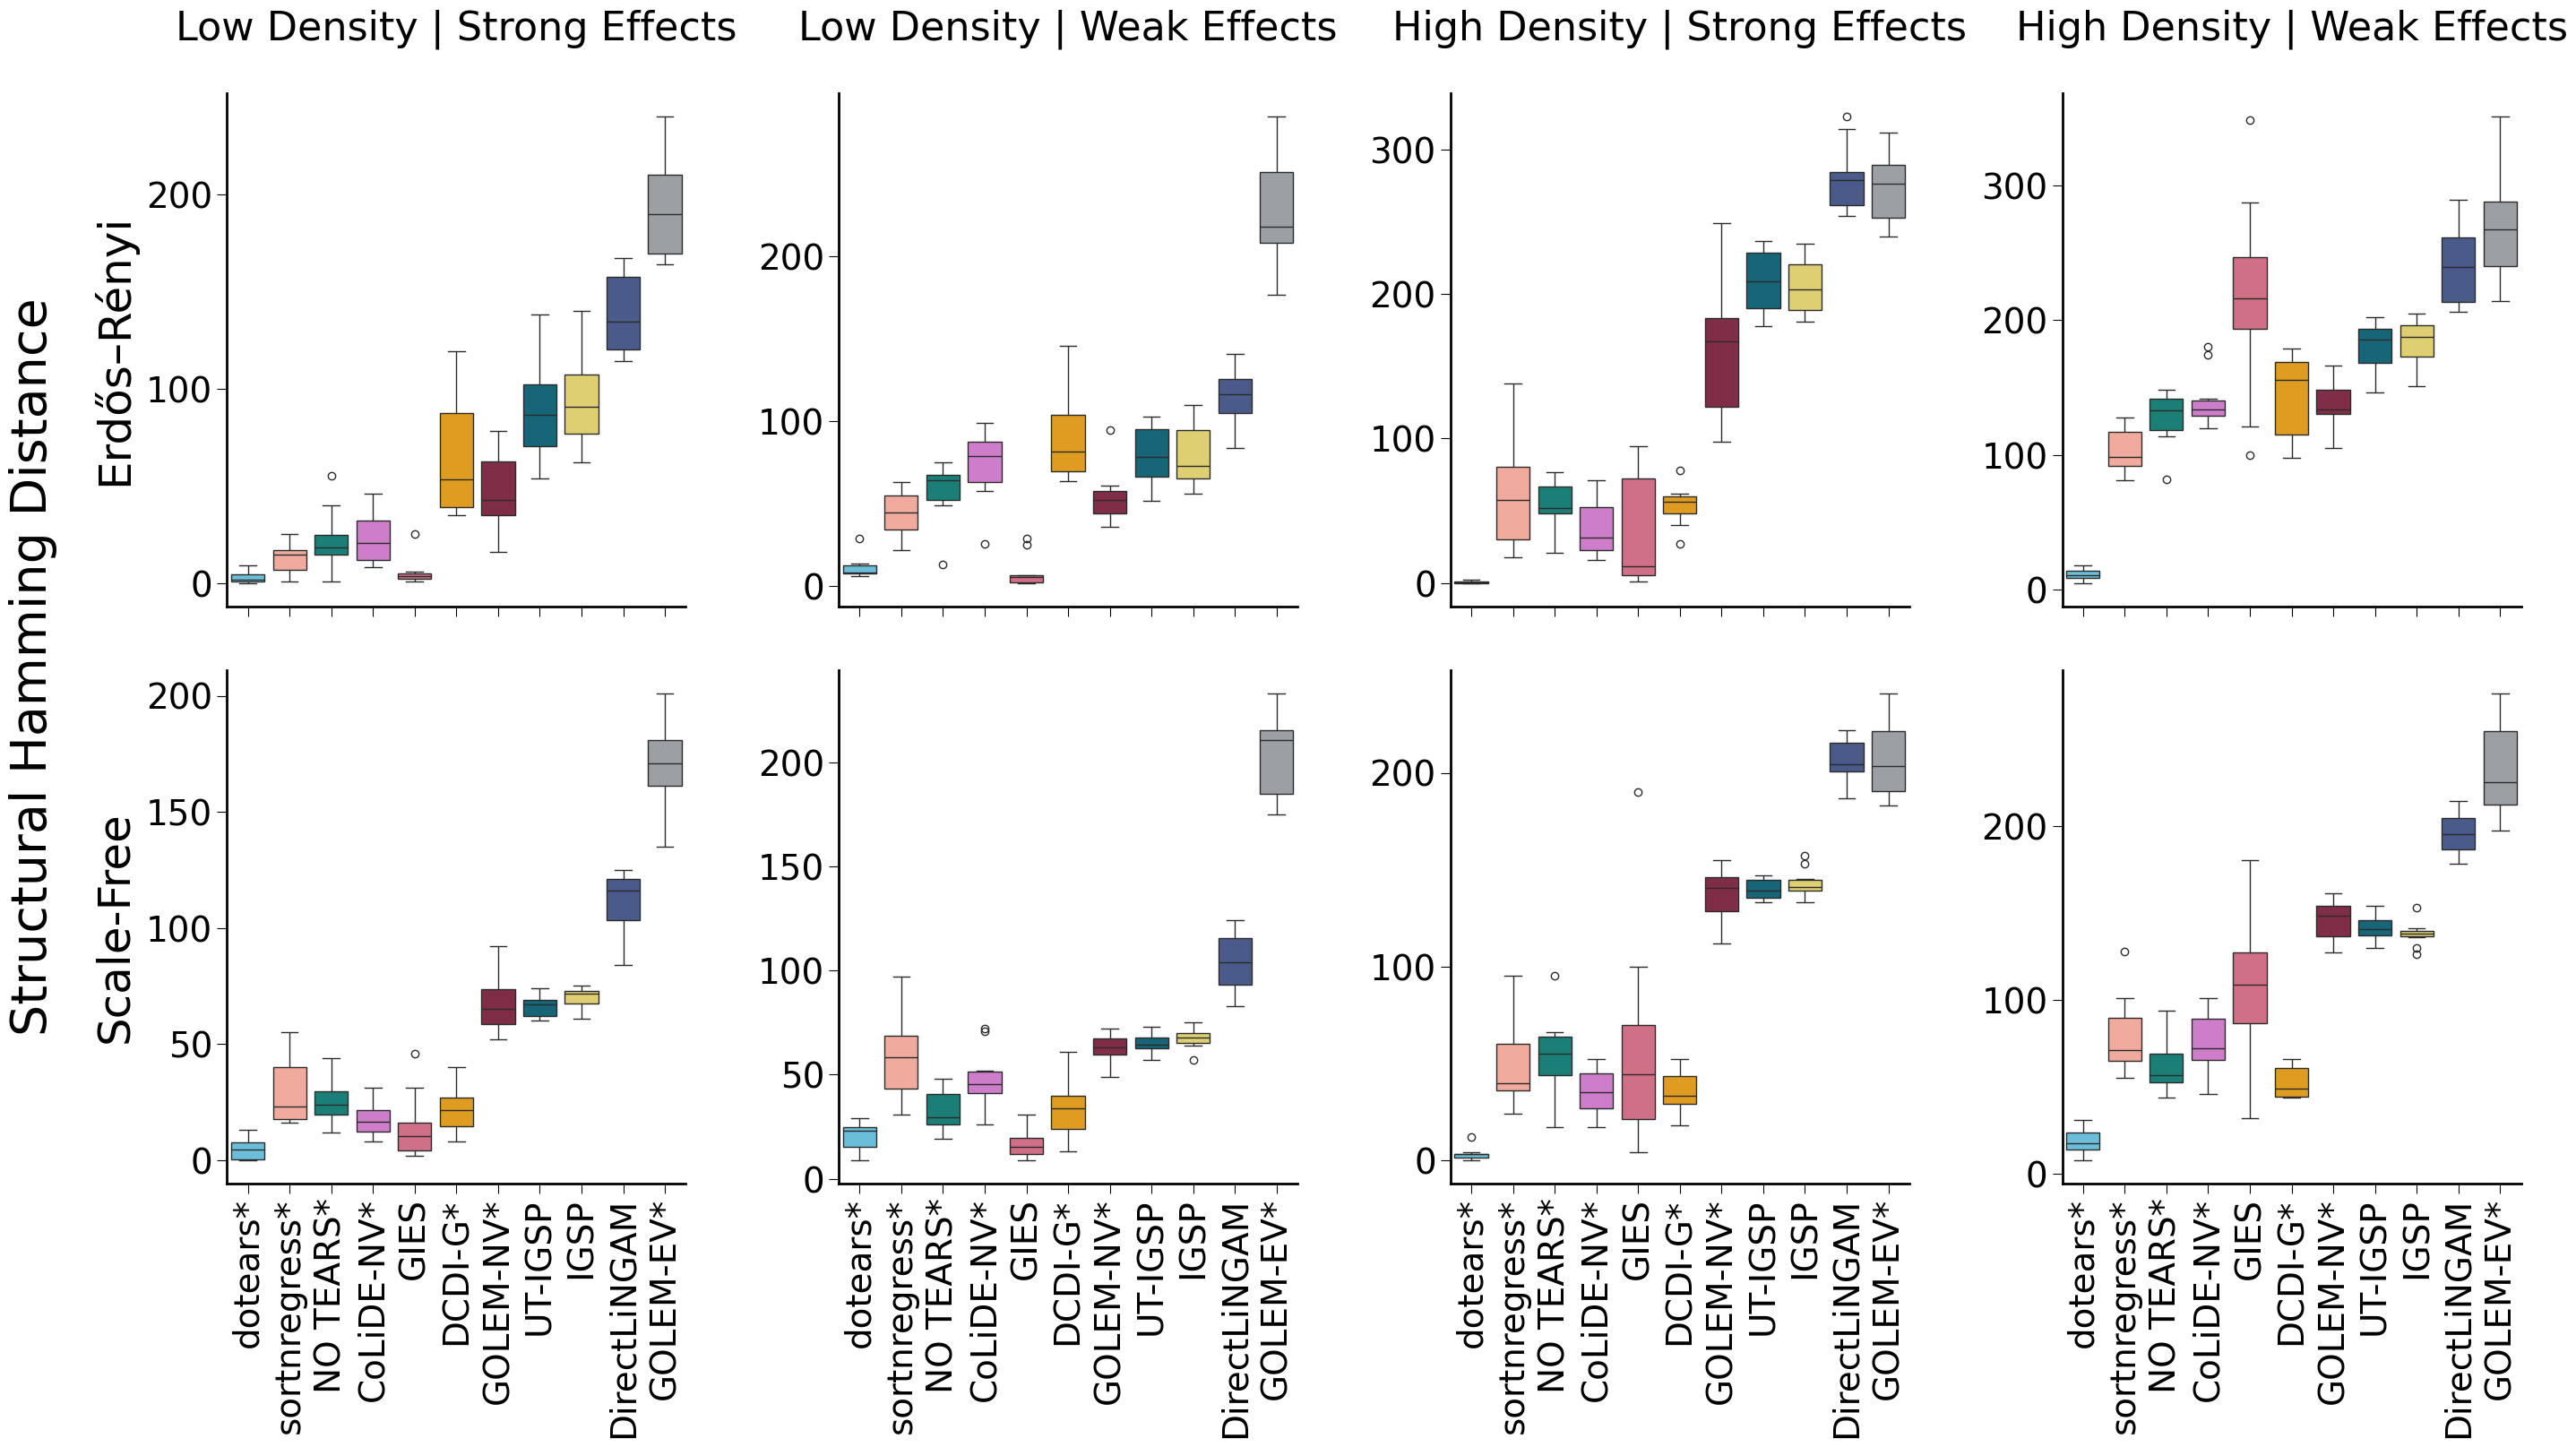

In [11]:

title_name_map = {
    'p40_high_density_strong_effects': 'High Density | Strong Effects',
    'p40_high_density_weak_effects': 'High Density | Weak Effects',
    'p40_low_density_strong_effects': 'Low Density | Strong Effects',
    'p40_low_density_weak_effects': 'Low Density | Weak Effects'
}


dag_name_map = {
    'erdos_renyi': r'Erd$o\H$s-R$\'{e}$nyi',
    'scale_free': 'Scale-Free'
}

COL_ORDER = [
    'p40_low_density_strong_effects',
    'p40_low_density_weak_effects',
    'p40_high_density_strong_effects',
    'p40_high_density_weak_effects',
]
# plt.figure(figsize=(12, 8))
ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[df['method'] == x, 'SHD'].mean())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

print(ORDERED_METHODS)
g = sns.FacetGrid(df, row='DAG type', col='sim type',
                  height=7,
                  aspect=1,
                  sharey=False,
                  col_order=COL_ORDER)

g.map(sns.boxplot, 'method', 'SHD',
      'method',
      order=ORDERED_METHODS,
      dodge=False,
      palette=color_dict)

fig = plt.gcf()
# print(fig.subfigures())
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        something = ax.get_xticklabels()
        ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
#         plt.xticks(rotation=90)
        title = ax.get_title()
        dag_type = title.split(' | ')[0].split(' = ')[-1]
        
        if i != 0:
            ax.set_title(None)
            
        if j == 0:
            if i == 0:
                ax.set_ylabel('Erdős–Rényi', fontsize=36)
            else:
                ax.set_ylabel('Scale-Free', fontsize=36)
            
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='major', labelsize=28)
        ax.tick_params(axis='y', which='major', labelsize=28)
        
        ax.locator_params(axis='y', nbins=5)
        
    if i == 0: 
        for ax in row:
            title = ax.get_title()
            print(title)
            sim_type = title.split('|')[-1].split(' = ')[-1]
            ax.set_title(title_name_map[sim_type] + '\n', fontsize=32)
g.fig.supylabel('Structural Hamming Distance', fontsize=40, x=-0.03)
plt.savefig('../../dotears/figures/all_sims/main.pdf',
            bbox_inches='tight', 
            dpi=300)
# plt.savefig('/u/home/a/asxue/project-hjp/poster_figures/main.svg',
#             bbox_inches='tight')

In [12]:
g.fig.text

<bound method FigureBase.text of <Figure size 2800x1400 with 8 Axes>>

Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

DAG type = erdos_renyi | sim type = p40_low_density_strong_effects
DAG type = erdos_renyi | sim type = p40_low_density_weak_effects
DAG type = erdos_renyi | sim type = p40_high_density_strong_effects
DAG type = erdos_renyi | sim type = p40_high_density_weak_effects


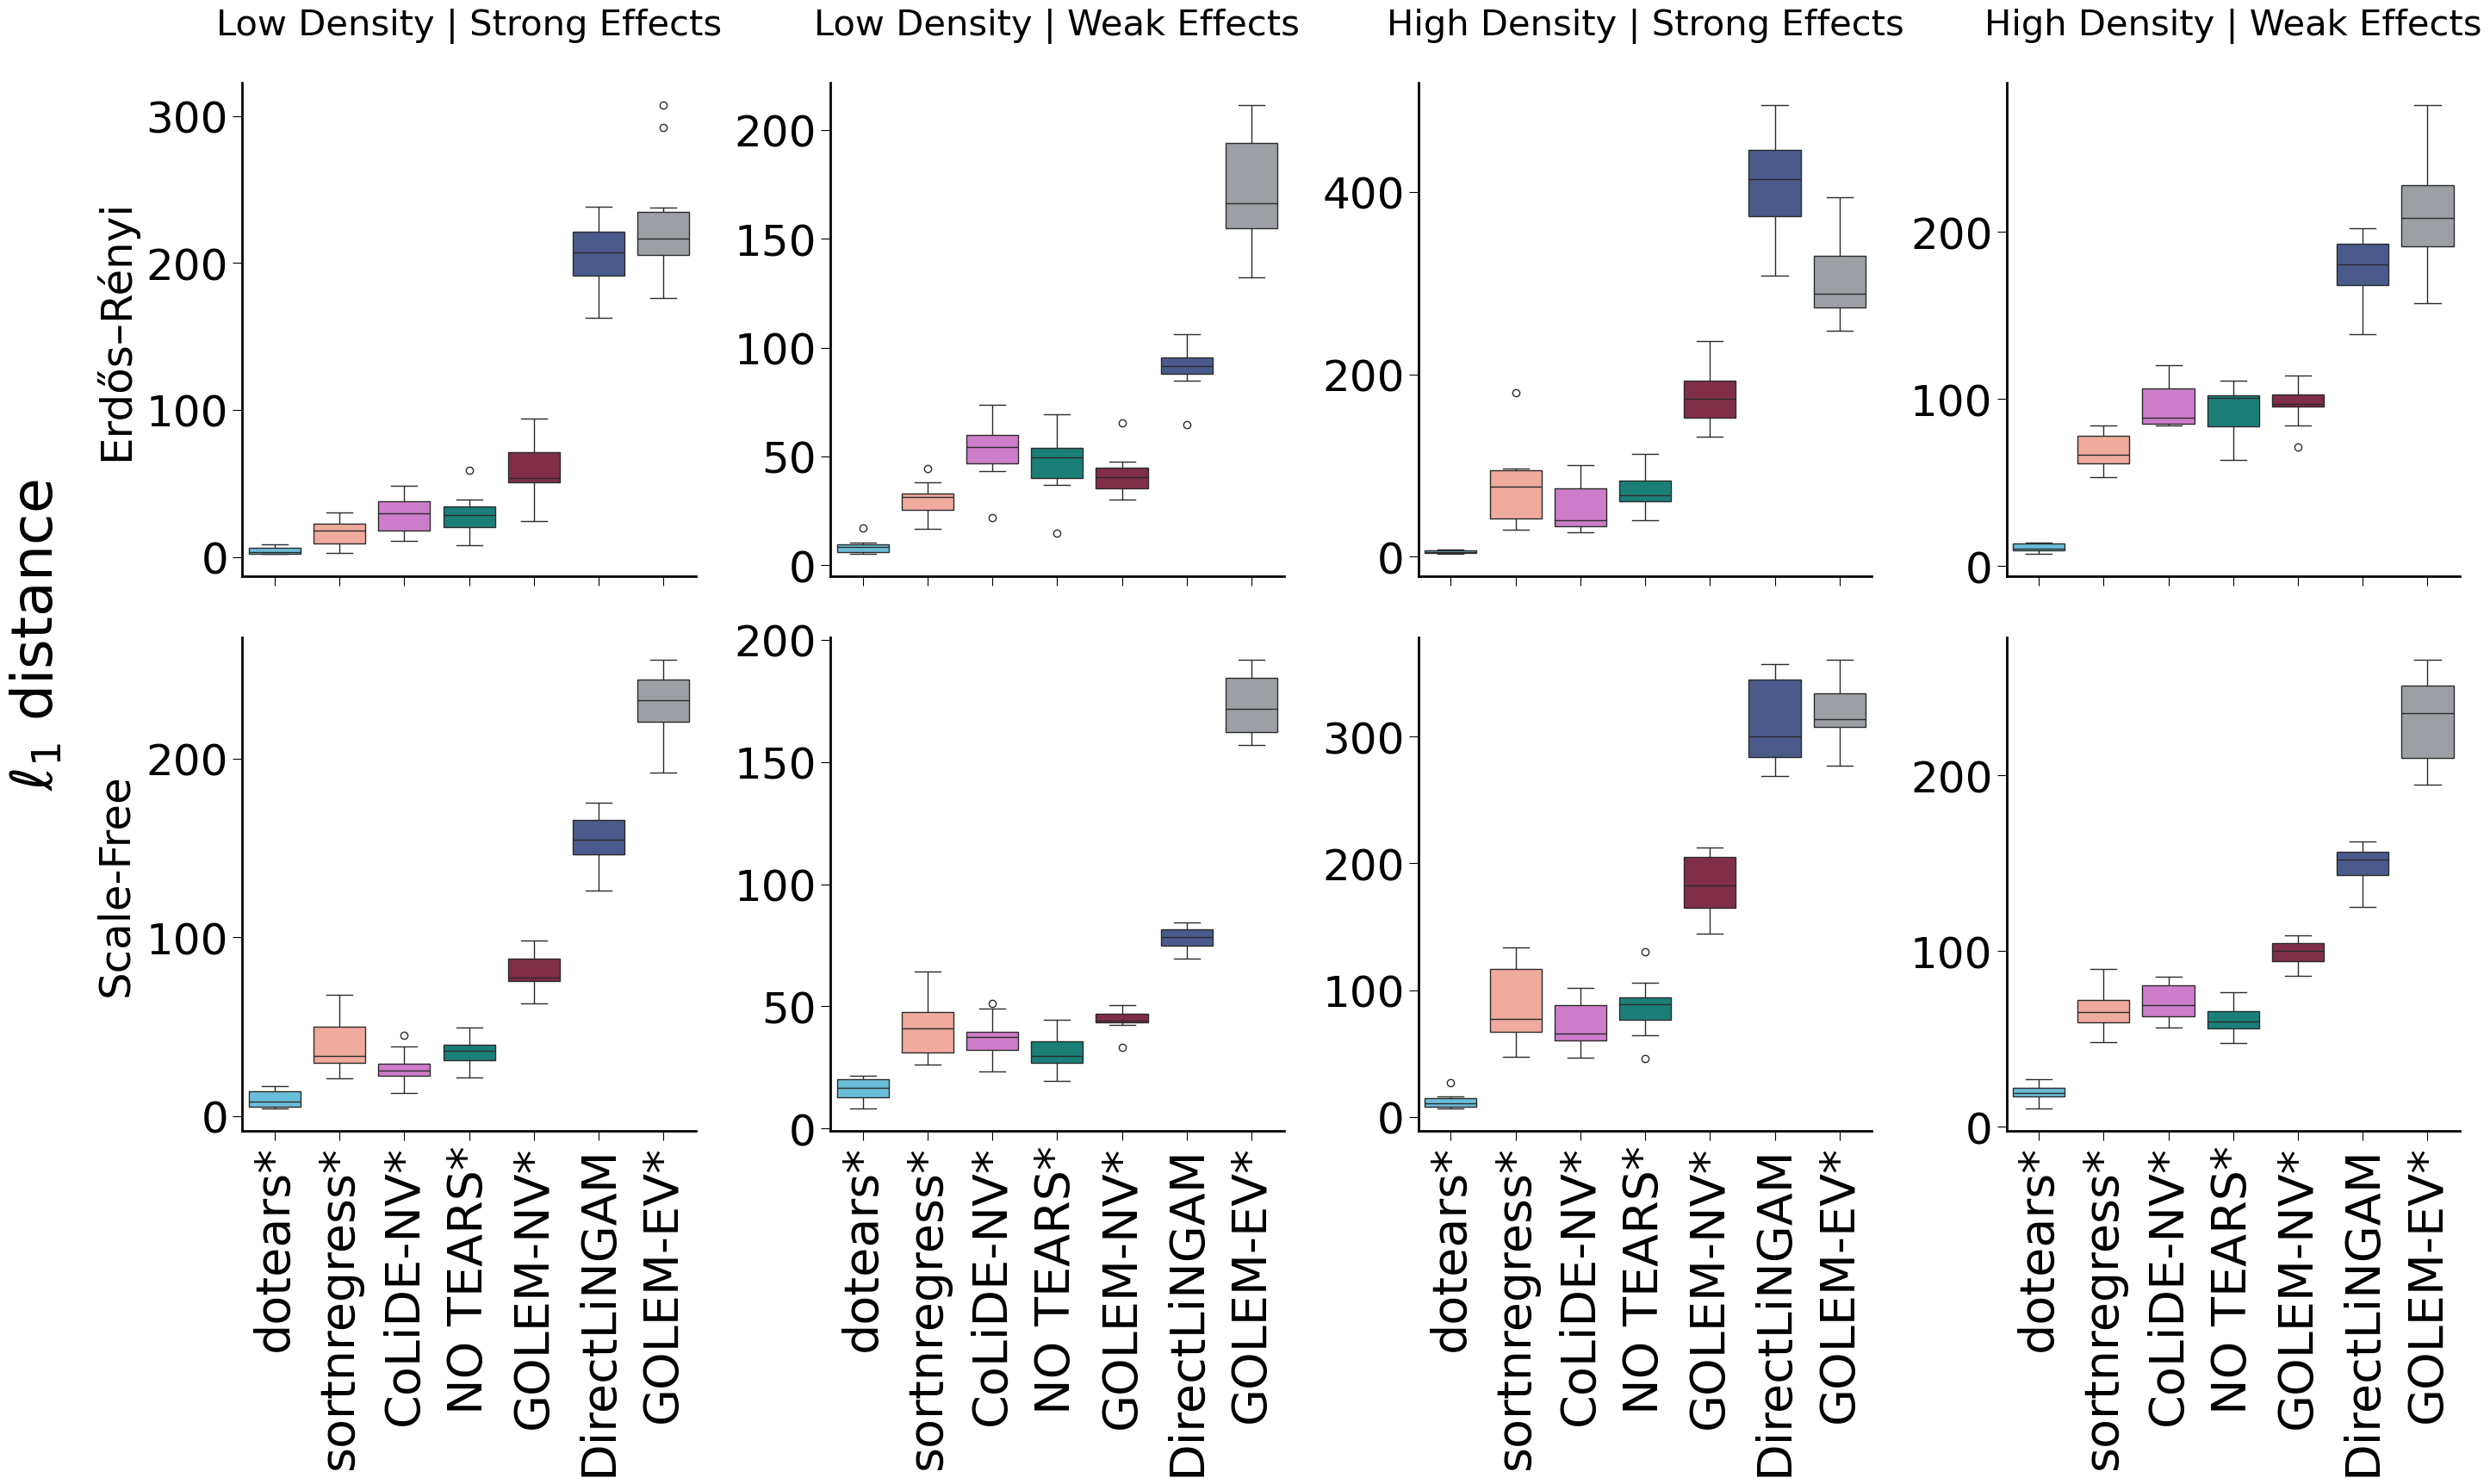

In [13]:

HUE_METHODS_L1 = ['dotears', 'notears', 'sortnregress', 'direct-lingam', 'golem-nv', 'golem-ev', 'colide-nv']
ORDERED_METHODS_L1 = sorted(HUE_METHODS_L1, key=lambda x: df.loc[df['method'] == x, 'L1 dist'].median())
DISPLAY_METHODS_L1 = [CV_NAME_DICT[x] for x in ORDERED_METHODS_L1]


L1_palette = [colormap[0]] + colormap[2:4] + colormap[5:]
# plt.figure(figsize=(12, 8))

g = sns.FacetGrid(df[df['method'] != 'gies'], row='DAG type', col='sim type',
                  height=7,
                  aspect=1,
                  sharey=False,
                  col_order = COL_ORDER)
g.map(sns.boxplot, 'method', 'L1 dist', 
      'method',
      dodge=False,
      order=ORDERED_METHODS_L1,
      palette=color_dict
     )

fig = plt.gcf()
# print(fig.subfigures())
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        something = ax.get_xticklabels()
        ax.set_xticklabels(DISPLAY_METHODS_L1, rotation=90)
#         plt.xticks(rotation=90)
        title = ax.get_title()
        dag_type = title.split(' | ')[0].split(' = ')[-1]
        
        if i != 0:
            ax.set_title(None)
            
        if j == 0:
            if i == 0:
                ax.set_ylabel('Erdős–Rényi', fontsize=36)
            else:
                ax.set_ylabel('Scale-Free', fontsize=36)
            
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='major', labelsize=40)
        ax.tick_params(axis='y', which='major', labelsize=36)
        
        ax.locator_params(axis='y', nbins=5)
        
    if i == 0: 
        for ax in row:
            title = ax.get_title()
            print(title)
            sim_type = title.split('|')[-1].split(' = ')[-1]
            ax.set_title(title_name_map[sim_type] + '\n', fontsize=30)

            
g.fig.supylabel(r'$\ell_1$ distance', fontsize=48, x=-0.04)

plt.savefig('../../dotears/figures/suppfig/all_sims_l1.png',
            dpi=72,
            bbox_inches='tight', 
           )

In [14]:
df['sim id'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object)

['dotears', 'sortnregress', 'notears', 'colide-nv', 'gies', 'dcdi-g', 'golem-nv', 'ut-igsp', 'igsp', 'direct-lingam', 'golem-ev']


Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

DAG type = erdos_renyi | sim type = p40_low_density_strong_effects
DAG type = erdos_renyi | sim type = p40_low_density_weak_effects
DAG type = erdos_renyi | sim type = p40_high_density_strong_effects
DAG type = erdos_renyi | sim type = p40_high_density_weak_effects


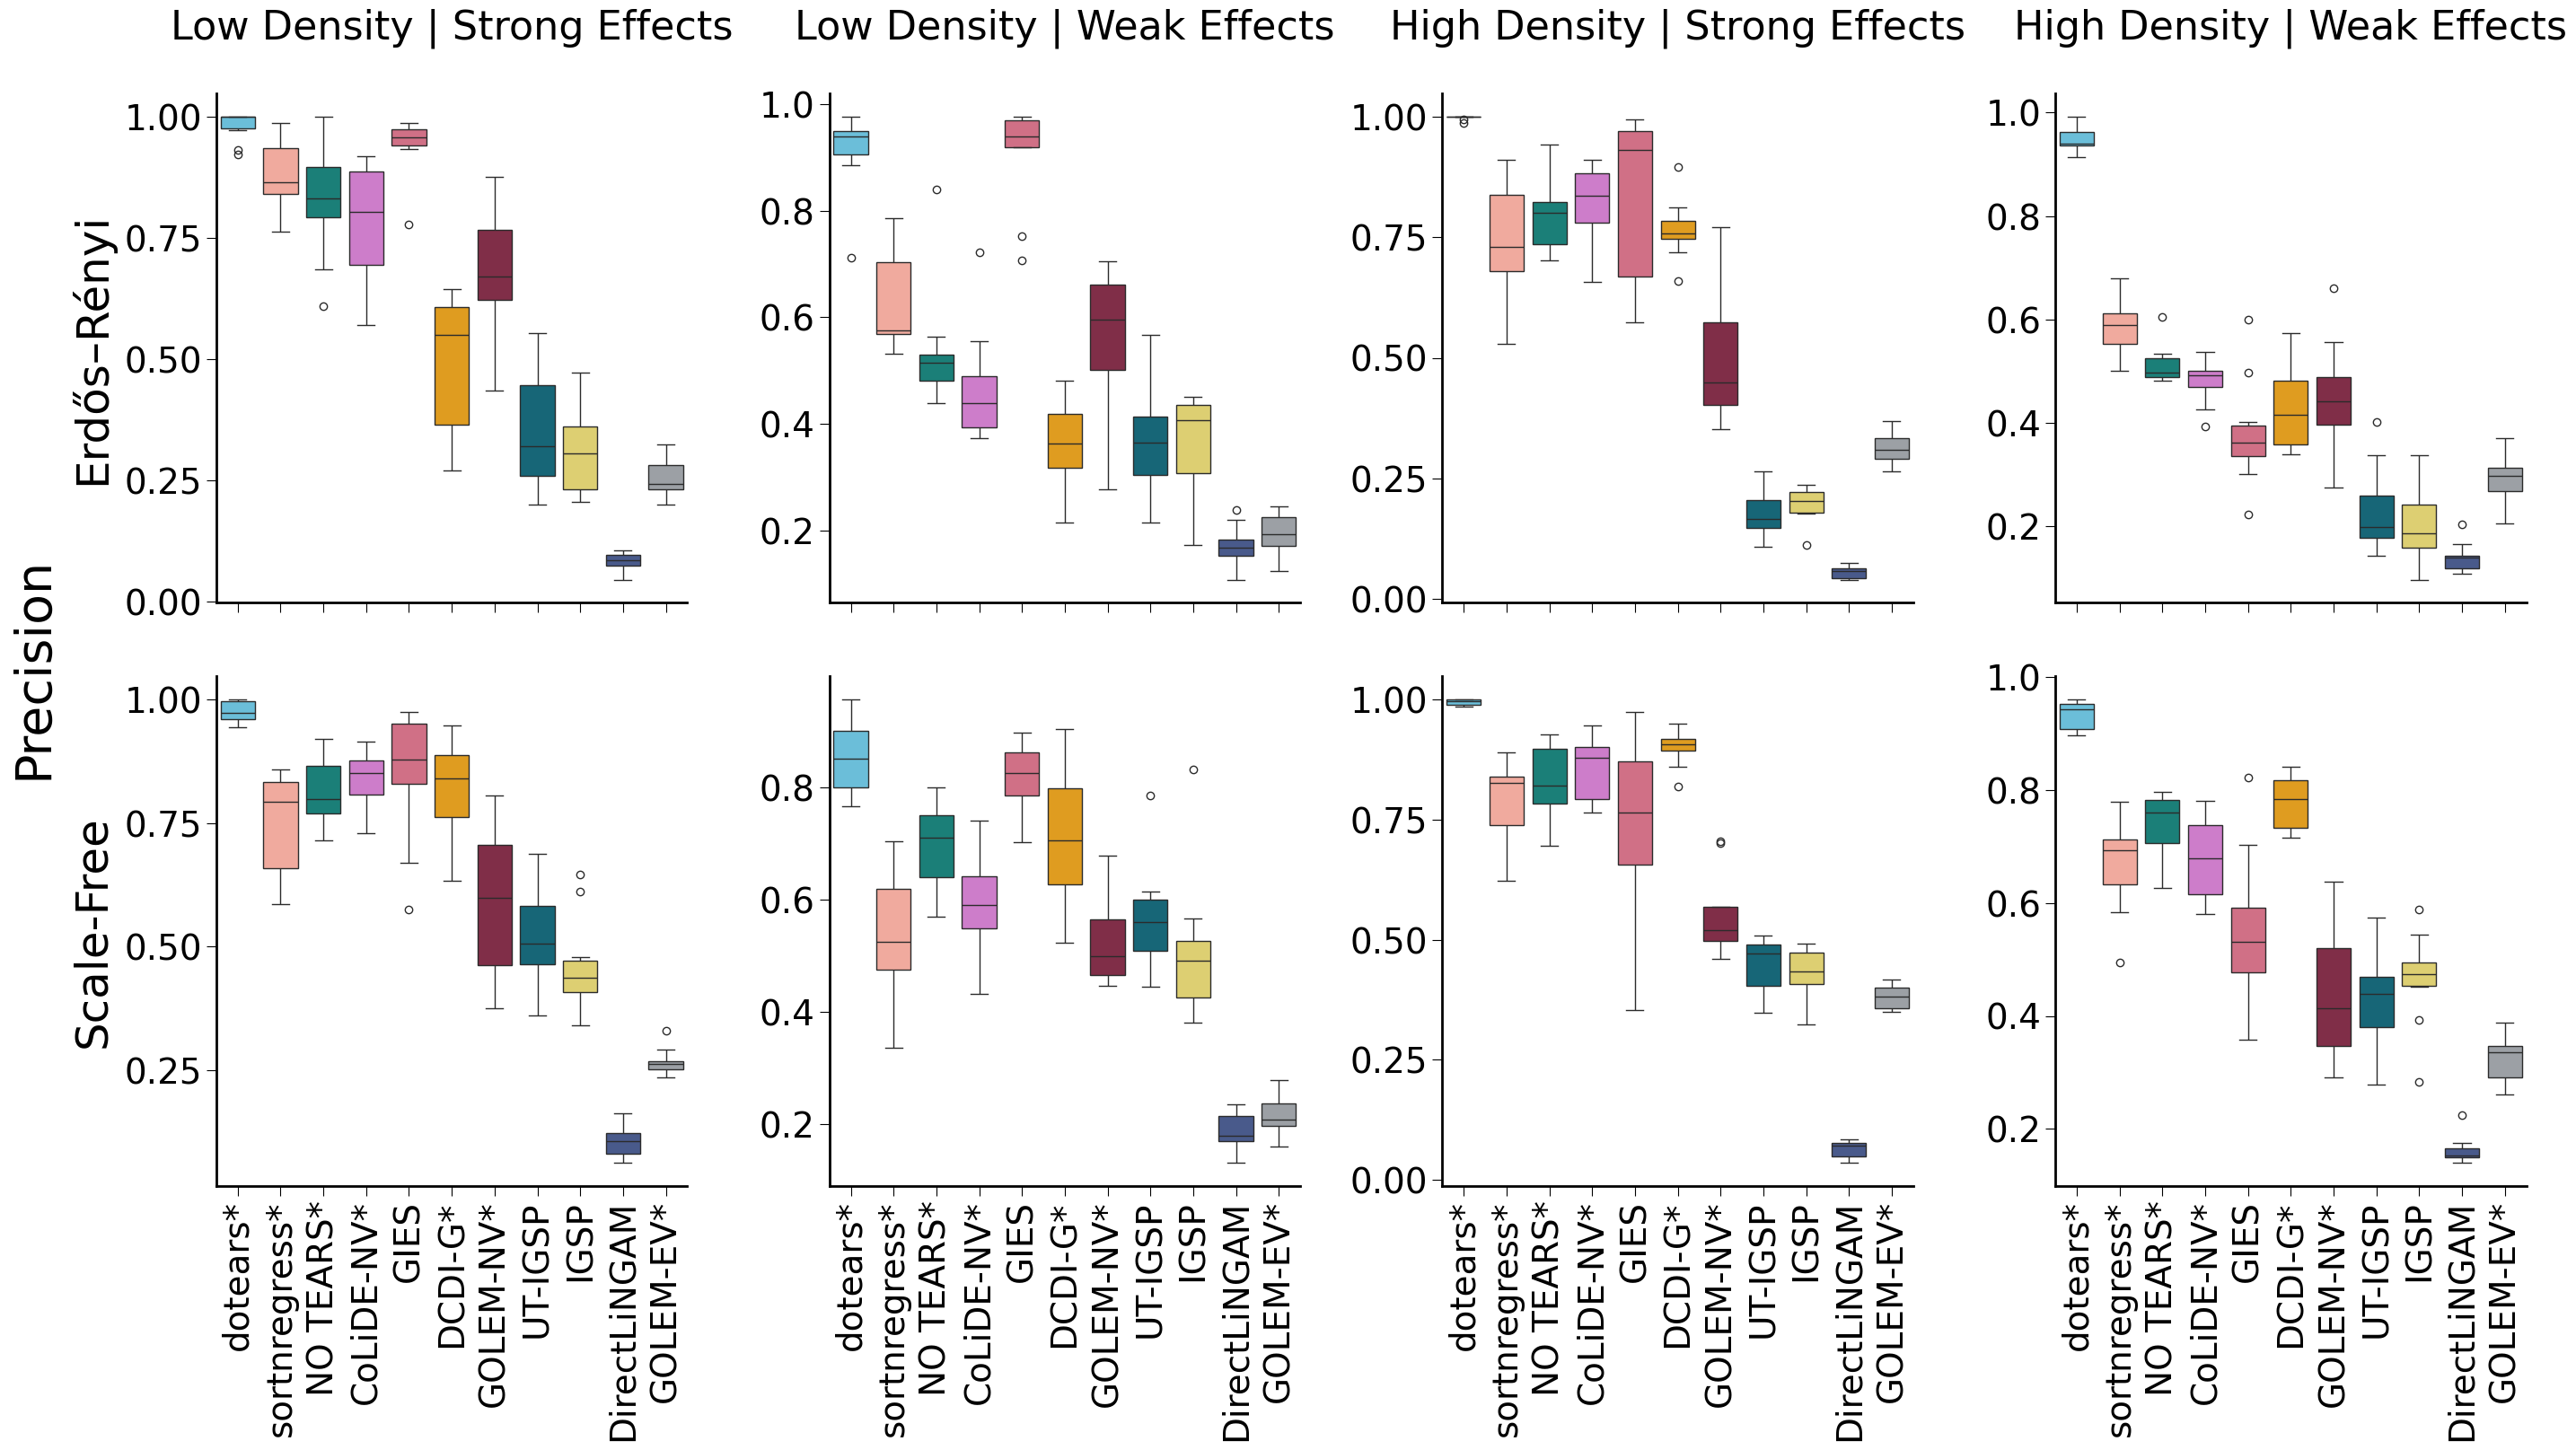

In [15]:

title_name_map = {
    'p40_high_density_strong_effects': 'High Density | Strong Effects',
    'p40_high_density_weak_effects': 'High Density | Weak Effects',
    'p40_low_density_strong_effects': 'Low Density | Strong Effects',
    'p40_low_density_weak_effects': 'Low Density | Weak Effects'
}


dag_name_map = {
    'erdos_renyi': r'Erd$o\H$s-R$\'{e}$nyi',
    'scale_free': 'Scale-Free'
}

COL_ORDER = [
    'p40_low_density_strong_effects',
    'p40_low_density_weak_effects',
    'p40_high_density_strong_effects',
    'p40_high_density_weak_effects',
]
# plt.figure(figsize=(12, 8))
ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[df['method'] == x, 'SHD'].mean())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

print(ORDERED_METHODS)
g = sns.FacetGrid(df, row='DAG type', col='sim type',
                  height=7,
                  aspect=1,
                  sharey=False,
                  col_order=COL_ORDER)

g.map(sns.boxplot, 'method', 'precision',
      'method',
      order=ORDERED_METHODS,
      dodge=False,
      palette=color_dict)

fig = plt.gcf()
# print(fig.subfigures())
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        something = ax.get_xticklabels()
        ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
#         plt.xticks(rotation=90)
        title = ax.get_title()
        dag_type = title.split(' | ')[0].split(' = ')[-1]
        
        if i != 0:
            ax.set_title(None)
            
        if j == 0:
            if i == 0:
                ax.set_ylabel('Erdős–Rényi', fontsize=36)
            else:
                ax.set_ylabel('Scale-Free', fontsize=36)
            
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='major', labelsize=28)
        ax.tick_params(axis='y', which='major', labelsize=28)
        
        ax.locator_params(axis='y', nbins=5)
        
    if i == 0: 
        for ax in row:
            title = ax.get_title()
            print(title)
            sim_type = title.split('|')[-1].split(' = ')[-1]
            ax.set_title(title_name_map[sim_type] + '\n', fontsize=32)
g.fig.supylabel('Precision', fontsize=40, x=-0.03)
plt.savefig('../../dotears/figures/suppfig/all_sims_precision.png',
            dpi=72,
            bbox_inches='tight', 
           )

['dotears', 'sortnregress', 'notears', 'colide-nv', 'gies', 'dcdi-g', 'golem-nv', 'ut-igsp', 'igsp', 'direct-lingam', 'golem-ev']


Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

DAG type = erdos_renyi | sim type = p40_low_density_strong_effects
DAG type = erdos_renyi | sim type = p40_low_density_weak_effects
DAG type = erdos_renyi | sim type = p40_high_density_strong_effects
DAG type = erdos_renyi | sim type = p40_high_density_weak_effects


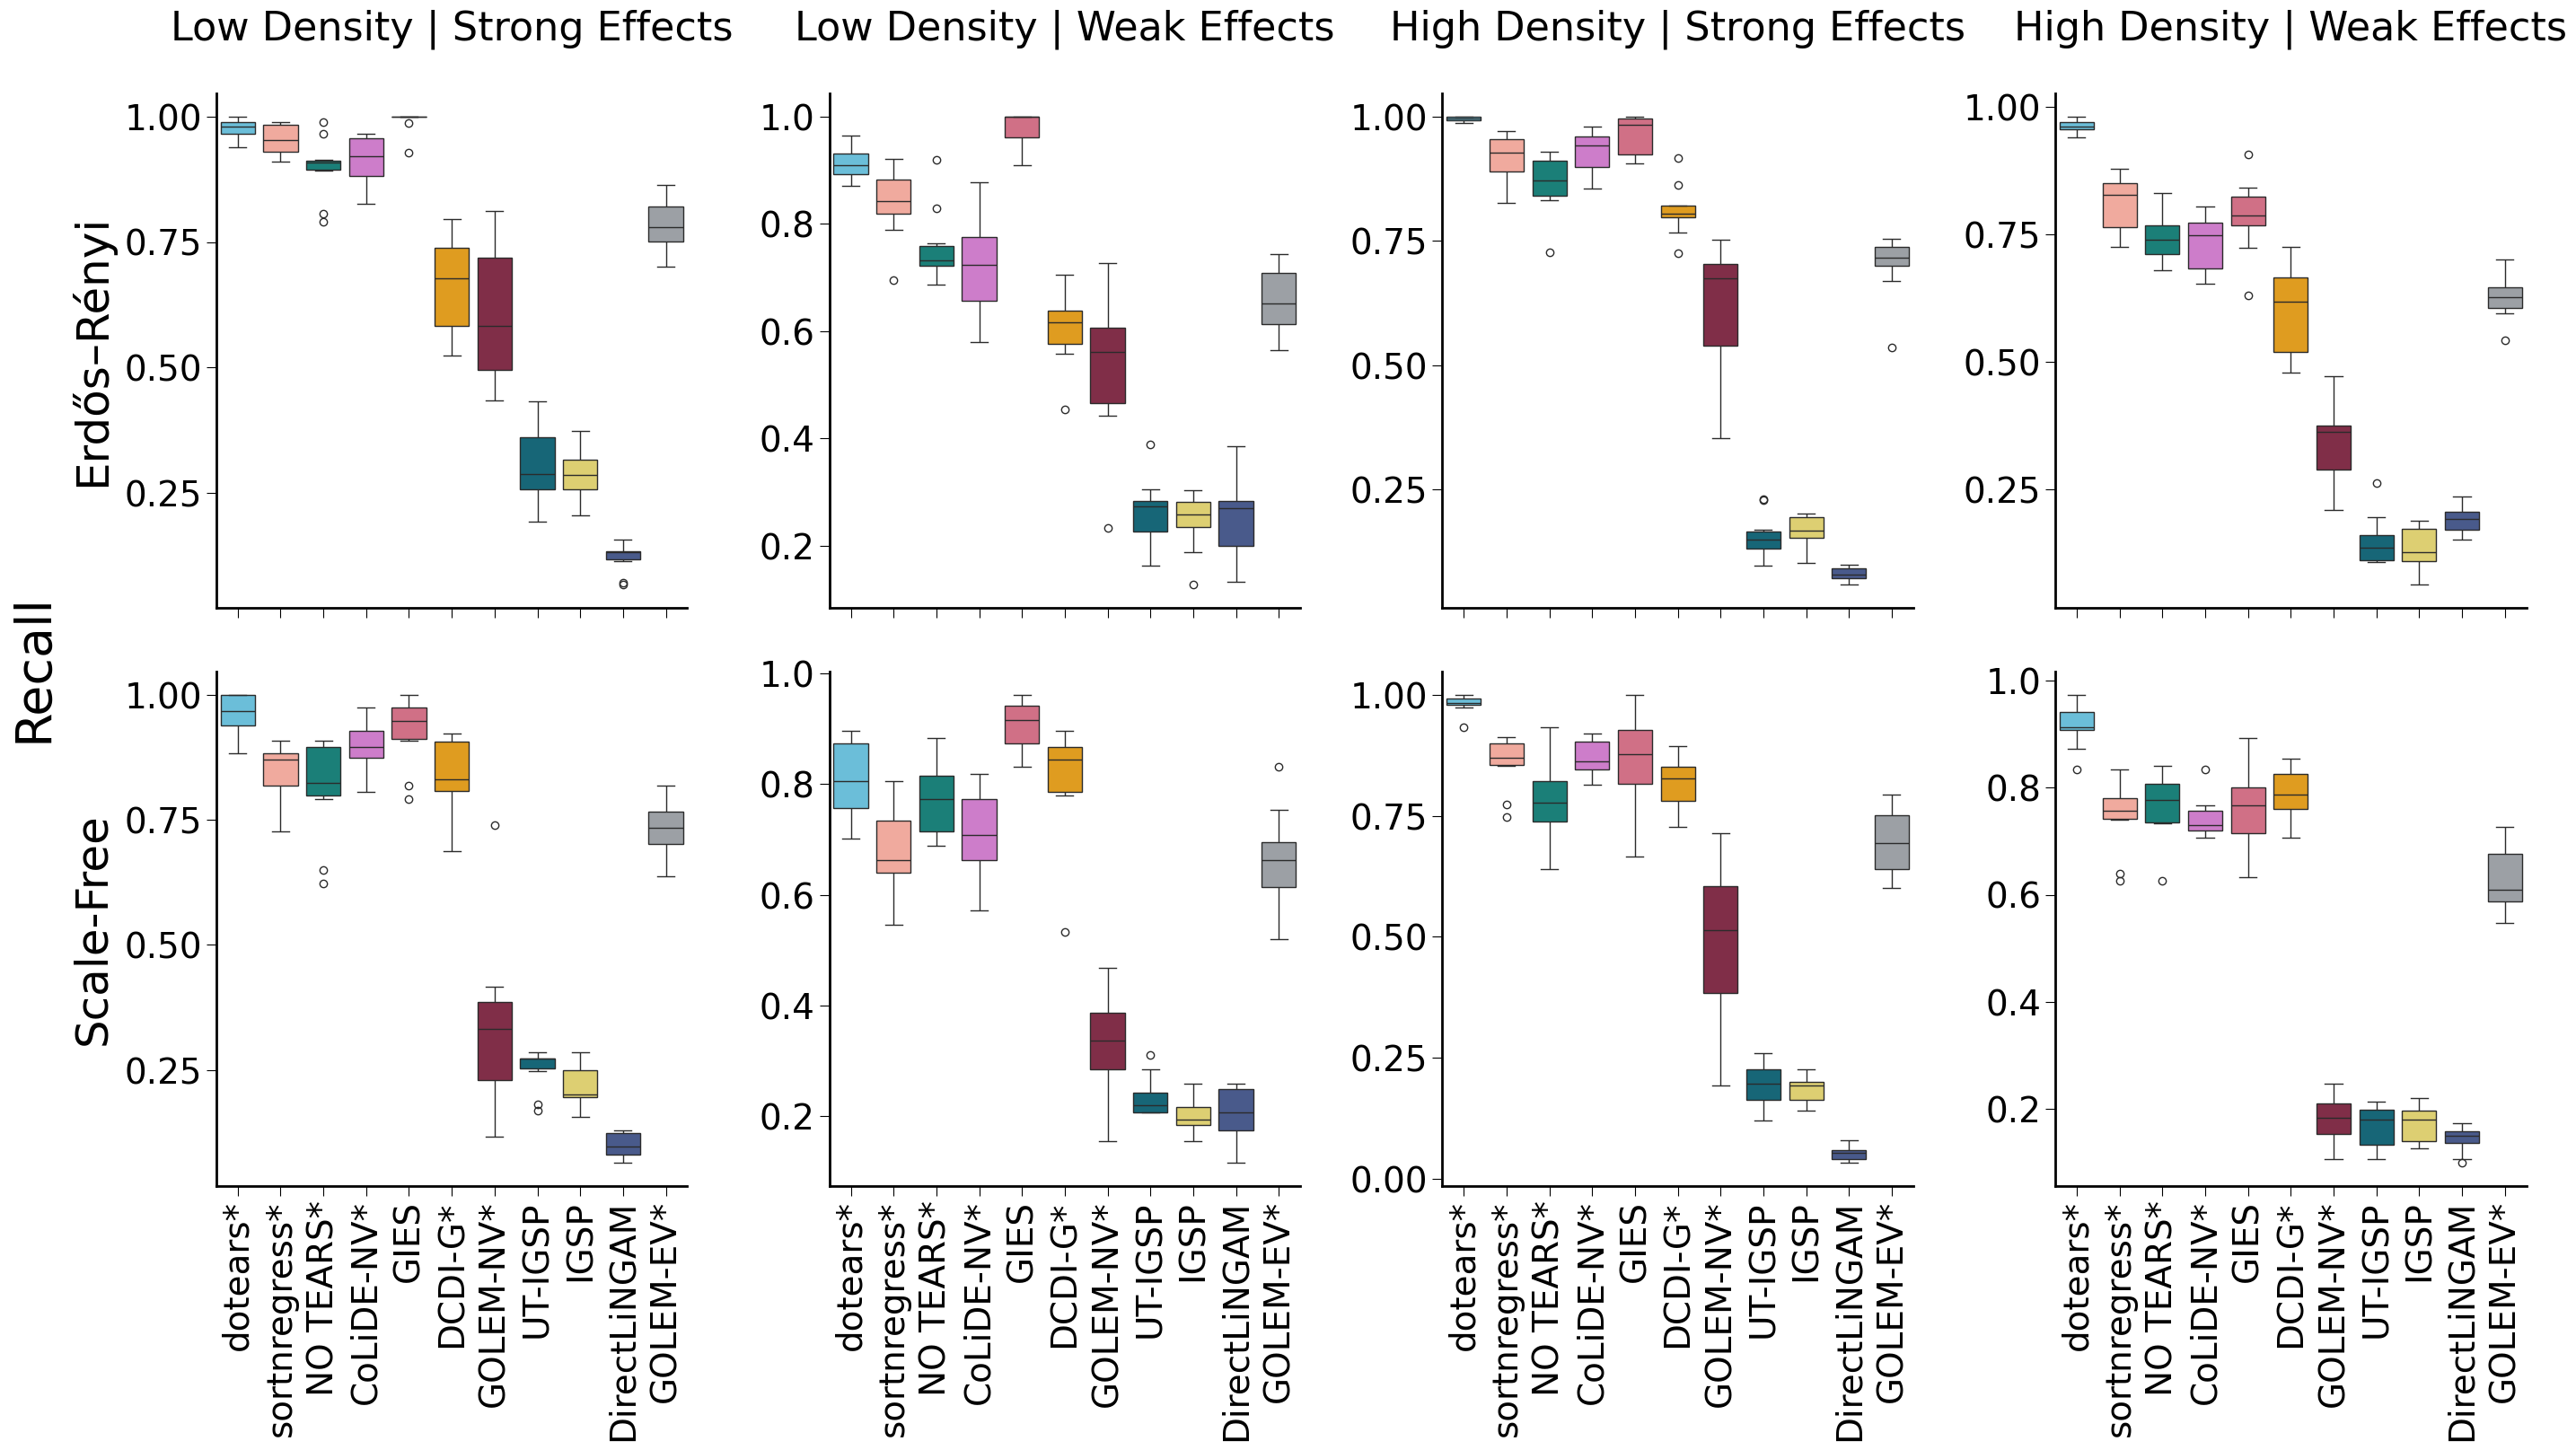

In [16]:

title_name_map = {
    'p40_high_density_strong_effects': 'High Density | Strong Effects',
    'p40_high_density_weak_effects': 'High Density | Weak Effects',
    'p40_low_density_strong_effects': 'Low Density | Strong Effects',
    'p40_low_density_weak_effects': 'Low Density | Weak Effects'
}


dag_name_map = {
    'erdos_renyi': r'Erd$o\H$s-R$\'{e}$nyi',
    'scale_free': 'Scale-Free'
}

COL_ORDER = [
    'p40_low_density_strong_effects',
    'p40_low_density_weak_effects',
    'p40_high_density_strong_effects',
    'p40_high_density_weak_effects',
]
# plt.figure(figsize=(12, 8))
ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[df['method'] == x, 'SHD'].mean())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

print(ORDERED_METHODS)
g = sns.FacetGrid(df, row='DAG type', col='sim type',
                  height=7,
                  aspect=1,
                  sharey=False,
                  col_order=COL_ORDER)

g.map(sns.boxplot, 'method', 'recall',
      'method',
      order=ORDERED_METHODS,
      dodge=False,
      palette=color_dict)

fig = plt.gcf()
# print(fig.subfigures())
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        something = ax.get_xticklabels()
        ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
#         plt.xticks(rotation=90)
        title = ax.get_title()
        dag_type = title.split(' | ')[0].split(' = ')[-1]
        
        if i != 0:
            ax.set_title(None)
            
        if j == 0:
            if i == 0:
                ax.set_ylabel('Erdős–Rényi', fontsize=36)
            else:
                ax.set_ylabel('Scale-Free', fontsize=36)
            
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='major', labelsize=28)
        ax.tick_params(axis='y', which='major', labelsize=28)
        
        ax.locator_params(axis='y', nbins=5)
        
    if i == 0: 
        for ax in row:
            title = ax.get_title()
            print(title)
            sim_type = title.split('|')[-1].split(' = ')[-1]
            ax.set_title(title_name_map[sim_type] + '\n', fontsize=32)
g.fig.supylabel('Recall', fontsize=40, x=-0.03)
plt.savefig('../../dotears/figures/suppfig/all_sims_recall.png',
            dpi=72,
            bbox_inches='tight', 
           )

In [17]:
total_edges = 0
denom = 0

printme = True

for w_true, W, method, dag_model, base_name in dags:
    if (dag_model == 'erdos_renyi') and 'high_density' in base_name:
        total_edges += binarize(w_true).sum()
        denom += 780
        
    if (dag_model == 'scale_free') and ('high_density' in base_name):
        if printme:
            print(binarize(w_true).sum())
            printme = False
        
print(total_edges / denom)

150
0.19641025641025642


In [18]:
experiment

'standard'